# ДЗ №6 - автокодировщики для идентификации аномалий

В этом ДЗ вам предстоит применить модель сврточного автокодировщика для идентификации аномалий в данных.

Для этого вам потребуется создать сверточный автокодировщик, обучить его и применить к тестовым данным.

Основная идея фильтрации аномалий состоит в том, что экземпляры выборки, являющиеся аномалиями, сильно отличаются от всех остальных объектов. Кроме того, их мало по сранению с размером всей выборки.
Этот набор факторов приводит к тому, что автокодировщик, обученный на данных тренировочной выборки, будет довольно плохо восстанавливать примеры-аномалии. То есть, значения функции потерь на таких примерах ожидается нетипично высоким.

In [1]:
# Эту ячейку следует выоплнять в окружении, в котором еще не установлены необходимые библиотеки. В подготовленном окружении эту ячейку можно пропустить.
!pip3 install torch torchvision numpy matplotlib

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image

from typing import Tuple, List, Type, Dict, Any

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Свёрточный автокодировщик (convolutional autoencoder, CAE)

Данными в этой задаче будут все так же набор рукописных цифр MNIST. Однако некоторые экземпляры тестовой выборки оказываются испорченными. Ваша цель - найти эти экземпляры в предположении, что они представляют собой аномалии.

Данные MNIST с дефектами нужно скачать в виде файла по <a href="https://www.dropbox.com/s/r7mgjn83y9ygpzq/mnist_corrupted.npz">ссылке</a>

Прежде всего следует построить и обучить свёрточный автокодировщик.

>Кодирующая часть автокодировщика (encoder, кодировщик) может состоять из сверточных слоев (convolutional layers) и слоев субдискретизации (pooling layers), но может быть и сложнее. Здесь предлагается применить ваши знания относительно возможной структуры сверточных сетей. Кодировщик, будучи обученным, позволяет извлечь скрытое представление (hidden representation, embeddings) входных примеров, содержащее достаточно информации для восстановления этих примеров декодером.

> Декодер (decoder) может состоять из слоев типа **transpose convolution** и операций масштабирования (upsampling), но также, как и кодировщик, может быть сложнее. Декодер должен восстанавливать примеры, руководствуюясь их векторами скрытого представления.

<img src='imgs/autoencoder_1.png' />

### Скрытое представление (hidden representation, compressed representation)

Скрытое представление может содержать семантически насыщенную информацию о входных примерах. С использованием этих данных можно проводить фильтрацию шума в примерах, восстанавливать сами примеры, и иногда даже проводить некоторые операции в семантическом пространстве.

В предположении, что файл данных `mnist_corrupted.npz` загружен и находится в той же директории, что и этот нотбук, генераторы данных можно описать следующим образом:

In [5]:
class DS(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)

In [6]:
#mnist = np.load('./mnist_corrupted.npz')
mnist = np.load('drive/MyDrive/for_collab/HW6_autoencoder/mnist_corrupted.npz')
mnist_train_samples = mnist['x_train']
mnist_test_samples = mnist['x_test']
train_dataset = DS(mnist_train_samples)
val_dataset = DS(mnist_test_samples)

### Визуализация исходных данных

Как и в любой задаче, имеет смысл визуализировать исходные данные, чтобы понимать, с чем мы имеем дело

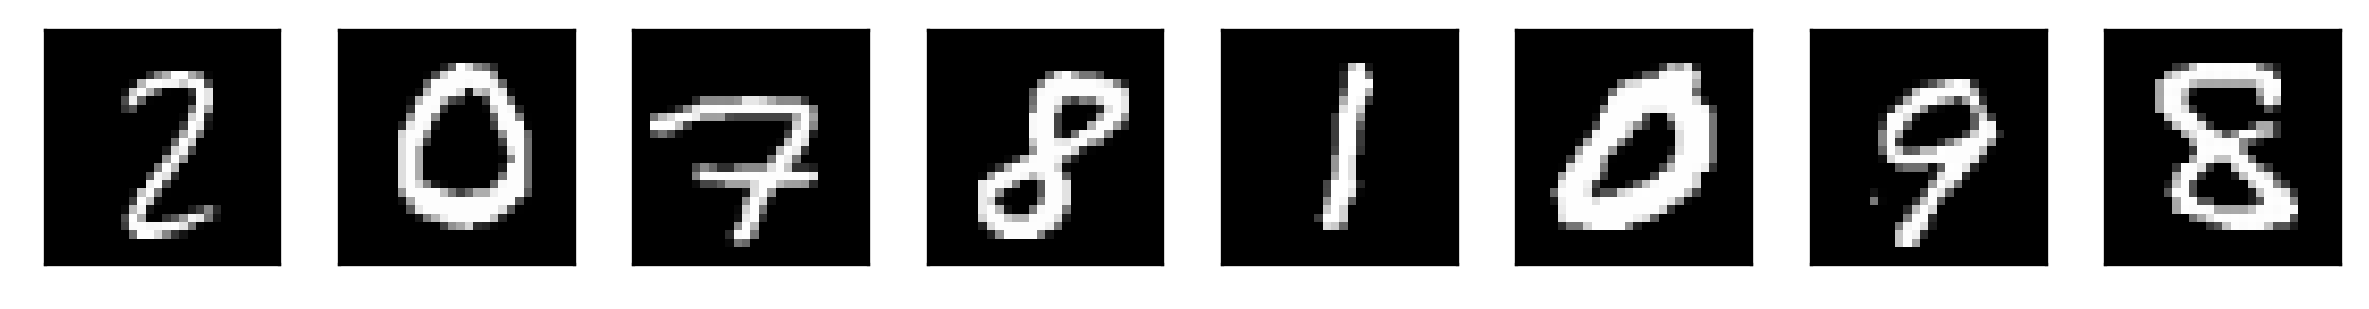

In [7]:
indices = np.random.randint(0, len(train_dataset), size=8)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    sample_index = indices[i]
    sample = train_dataset[sample_index]
    ax.imshow(np.squeeze(sample), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

---
## Свёрточный автокодировщик

#### Кодировщик (Encoder)
Кодировщик можно реализовать в подходе AlexNet или VGG: сверточные (convolutional) слои чередуются со слоями субдискретизации (pooling). Последние применяются для снижения пространственных размерностей промежуточных представлений входных примеров. Нередко после сверточной части добавляют дополнительные полносвязные слои, позволяющие еще сильнее снизить размерность скрытого представления, извлекаемого кодировщиком.

Предлагаемая структура кодировщика не единственно верная. Можно реализовывать и другие.

#### Декодер

Декодер должен преобразовать вектор скрытого представления (тензор ранга 1) в изображение, реконструкцию входного примера. Для этого следует вектор скрытого представления перевести в ранг 2 (например, операцией `.view()`). После этого следует последовательно применять операции Transpose Convolution (`torch.nn.ConvTranspose2d`) и масштабирования (upsampling, а именно `torch.nn.functional.interpolate`). В некоторых случаях применяют `torch.nn.ConvTranspose2d` с аргументом `stride=2` или больше. Однако такое использование может привести в т.н. ["эффекту шахматной доски"](https://distill.pub/2016/deconv-checkerboard/). Рекомендуемым вариантом сейчас считается применение масштабирования типа билинейного или бикубического.

Результатом работы декодера должно получиться изображение, по размеру совпадающее с входным примером, то есть, 28x28.

Не следует забывать, что одной из целей применения автокодировщиков является снижение размерности примеров с сохранением ключевой информации. Экспериментируйте с количеством слоев и размерностью скрытого представления! Попробуйте снизить его до 2 или вообще до 1. Хорошо ли будут воспроизводиться примеры выборки?

### Transpose Convolutions

В этом ДЗ в декодере предлагается использовать слои типа **transposed convolutional**. Они работают практически так же, как свёрточные слои, но "задом наперед". Например, ядро размером 3x3 в случае свёрточной операции дает в результате одно значение. Операция **transposed convolutional**, наоборот, одно значение входного представления трансформирует в патч размером с его ядро (3x3). В PyTorch есть уже готовая реализация слоев [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d).

Повторимся, альтернативой использованию **transposed convolutional layer** с аргументом `stride=2` или больше может быть применение операций изменения размера (resizing) с интерполяцией типа "nearest neighbor", "bilinear" или "bicubic" и применением свёрточной операции к результату.

### Задание 1:  Описать класс нейросети-автокодировщика, описываемой в этом задании.

Параметры Conv2d и ConvTranspose2d для соответствия количества выходных элементов желаемым высчитывались с использованием следующих формул:
Conv2d:
$$
H_{out} = \frac{H_{in} + 2*padding - dilation*(kernel\_size - 1) -1}{stride} + 1 $$   
ConvTranspose2d:
$$
H_{out} = (H_{in} - 1) * stride - 2*padding + dilation*(kernel\_size - 1) + 1 $$    

In [8]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_num=26):
        super(ConvAutoencoder, self).__init__()
        ## слои кодировщика ##
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(16, 4, kernel_size=3, padding=1, stride=2)
        self.lin1 = nn.Linear(196, embedding_num)
        
        ## слои декодера ##
        self.lin2 = nn.Linear(embedding_num, 196)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        ## применить операции кодировщика ##
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x_shape = x.shape
        x = x.view((-1, np.product(x_shape[1:])))
        x = F.gelu(self.lin1(x))
        
        ## применить операции декодера ##
        x = F.gelu(self.lin2(x))
        x = x.view([-1]+list(x_shape[1:]))
        x = nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True)(x)
        x = F.gelu(self.t_conv1(x))
        x = nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True)(x)
        x = F.gelu(self.t_conv2(x))
        # x = torch.sigmoid(x)
        ## В случае, если данные отнормированы к диапазону [0,1], активацией последнего слоя может быть sigmoid.
        ## Подумайте, какая может быть функция активации в других случаях. Реализуйте подходящий вариант
                        
        return x

In [9]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lin1): Linear(in_features=196, out_features=26, bias=True)
  (lin2): Linear(in_features=26, out_features=196, bias=True)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [10]:
model = model.to(device)

### Задание 2: Напишите пайплайн для предобработки и аугументации данных.

В `torchvision.transforms` есть готовые реализации большинства распространённых техник, если вы хотите добавить что-то своё, вы можете воспользоваться `torchvision.transforms.Lambda` или встроить аугментации на этапе подготовки данных в классе `DS`.

In [11]:
loader = torch.utils.data.DataLoader(train_dataset,
                         batch_size=60,
                         num_workers=0,
                         shuffle=False)

mean = 0.
std = 0.
for images in loader:
    images = images/255
    batch_samples = images.size(0)
    images = images.view(batch_samples, 1, -1)
    mean += images.type(torch.float).mean(2).sum(0)
    std += images.type(torch.float).std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
print(f'mean: {mean}, std: {std}')

mean: tensor([0.1307]), std: tensor([0.3015])


In [12]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.7, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=20),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3015,))
    ])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3015,))
    ])

Всегда имеет смысл посмотреть, как происходит предобработка данных, и как происходит обработка данных нейросетью (если это возможно). В этом ДЗ предлагается визуализировать произвольные примеры из обучающей выборки, а также один из произвольных примеров, обработанных только что созданной (но не обученной) моделью.

### Задание 3: отобразите несколько произвольных примеров обучающей выборки.

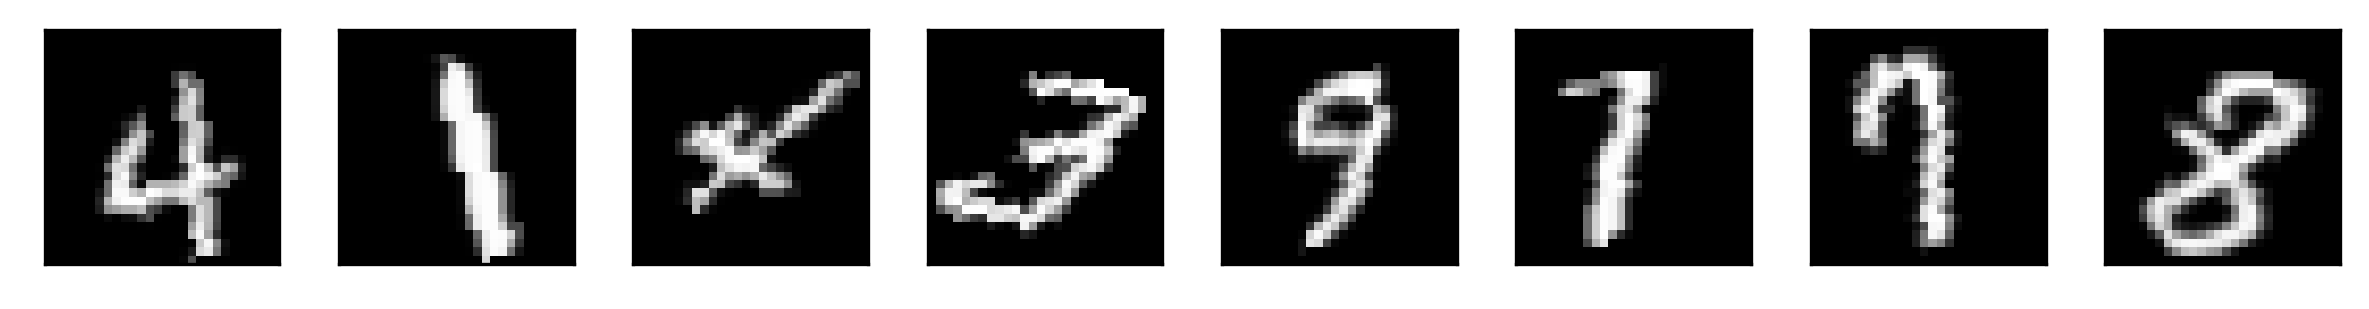

In [13]:
#mnist = np.load('./mnist_corrupted.npz')
mnist = np.load('drive/MyDrive/for_collab/HW6_autoencoder/mnist_corrupted.npz')
mnist_train_samples = mnist['x_train']
mnist_test_samples = mnist['x_test']
train_dataset = DS(mnist_train_samples, train_transforms)
val_dataset = DS(mnist_test_samples, val_transforms)

indices = np.random.randint(0, len(train_dataset), size=8)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    sample_index = indices[i]
    sample = train_dataset[sample_index]
    ax.imshow(np.squeeze(sample), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

### Задание 4: отобразите один произвольный пример обучающей выборки и результат вычисления нейросети на этом примере.

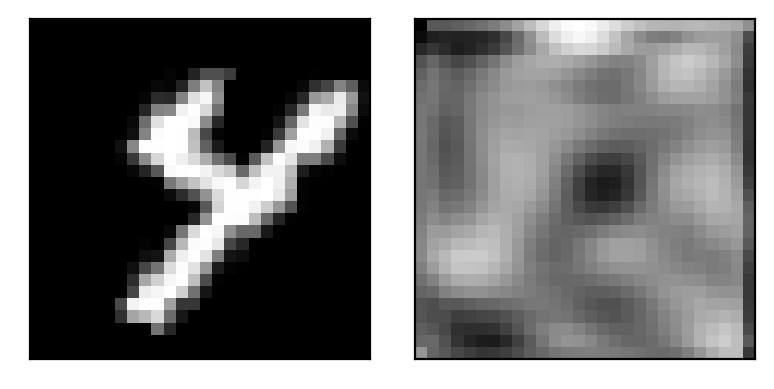

In [14]:
index = int(np.random.randint(0, len(train_dataset), size=1))
sample = train_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

### Обучение модели

Теперь, когда вы реализовали модель и подготовили данные, можно приступить к непосредственному обучению модели.

Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [15]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                optimizer_params: Dict = {},
                initial_lr = 0.001,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 10,
                early_stopping_patience = 10
):
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1} of {max_epochs}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
#             torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

### Задание 5:  Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`.
> ВНИМАНИЕ!!! В задаче обучения автокодировщика нет меток-цифр. Есть только входные примеры. При итерировании по `data_loader` вы будете получать только сами примеры! Подумайте, что должно выступать в качестве целевой переменной, когда вы вычисляете функцию потерь.

**Ответ**    
В качестве функции потерь будем использовать MSE, оценивая с помощью неё отличие от истинного значения каждого пикселя в выстроенной декодером картинке

In [16]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    
    # Initialize the loss function
    loss_fn = loss_function
    size = len(data_loader.dataset)
    
    for batch, X in enumerate(data_loader):
        # Transfer to device
        X = X.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Задание 6:  Реализуйте функцию производящую расчёт функции потерь на тестовой выборке.  На вход будет приходить модель, функция потерь и DataLoader. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [17]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0.0
    
    loss_fn = loss_function
    size = len(data_loader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample in data_loader:
            # Transfer to device
            sample = sample.to(device)
            pred = model(sample)
            test_loss += loss_fn(pred, sample).item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return {'loss': test_loss}

Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения.

### Задание 7: придумайте функцию потерь.

Обратите внимание, что в предложенном скелетном коде функция потерь по умолчанию прописана неверно. Вы, скорее всего, не сможете обучить автокодировщик с этой функцией потерь. Подумайте, какая должна быть функция потерь при условии, что она должна оценивать качество воспроизведения значений в каждом отдельном пикселе изображения. Впишите в ячейке ниже правильную функцию потерь. Подумайте, можно ли использовать уже предложенную функцию потерь, и что нужно сделать с данными, чтобы с ней можно было обучить вашу модель.

---------------

**Ответ**    
Предложенную функцию потерь (CrossEntropy) использовать можно, переходя к вероятностной постановке задачи. Для этого нужно привести данные к виду [0,1] (в общем-то это же всё равно всегда делает функция ToTensor()) и затем выпрямить данные в вектор перел вычислении CrossEntropy.   
Однако, это несет в себе некоторые негативные последствия, тк значения пикселей между собой имеют корреляцию. Кроме того, функция потерь CrossEntropy не симметрична относительно верного значения. Если верное значение пикселя равно 0.8 для нас не должно иметь концептуальной разницы, предсказали ли мы 0.9 или 0.7. Ошибка должна быть одной и той же, что не выполняется в случае применения CrossEntropy.
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


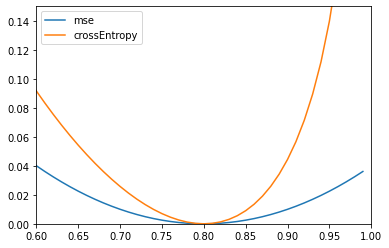

In [18]:
x = np.array([i for i in range(100)])/100
expected_value=0.8
mse = abs(x-expected_value)**2
CrossEntropy = -(expected_value*np.log(x) + (1-expected_value)*np.log(1-x))
plt.plot(x, mse, label='mse')
plt.plot(x, CrossEntropy - min(CrossEntropy), label = 'crossEntropy')
plt.xlim(0.6,1.0)
plt.ylim(0,0.15)
plt.legend()

------------------

In [19]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.MSELoss(), 
            initial_lr=0.0001
            )

Epoch 1 of 10
loss: 0.103928  [    0/60000]
loss: 0.058408  [ 6400/60000]
loss: 0.040080  [12800/60000]
loss: 0.034942  [19200/60000]
loss: 0.032687  [25600/60000]
loss: 0.030686  [32000/60000]
loss: 0.028123  [38400/60000]
loss: 0.029454  [44800/60000]
loss: 0.026936  [51200/60000]
loss: 0.024625  [57600/60000]
Test Error: 
 Avg loss: 0.000424 

Validation metrics: 
{'loss': 0.0004238707421347499}
Best model yet, saving
Epoch 2 of 10
loss: 0.023718  [    0/60000]
loss: 0.024134  [ 6400/60000]
loss: 0.023693  [12800/60000]
loss: 0.023071  [19200/60000]
loss: 0.021968  [25600/60000]
loss: 0.021423  [32000/60000]
loss: 0.020903  [38400/60000]
loss: 0.021644  [44800/60000]
loss: 0.018639  [51200/60000]
loss: 0.020755  [57600/60000]
Test Error: 
 Avg loss: 0.000354 

Validation metrics: 
{'loss': 0.0003542908122763038}
Best model yet, saving
Epoch 3 of 10
loss: 0.018979  [    0/60000]
loss: 0.023296  [ 6400/60000]
loss: 0.018229  [12800/60000]
loss: 0.019516  [19200/60000]
loss: 0.018204  

## Проверка результатов

Посмотрите, как ваш обученный автокодировщик преобразует входные примеры. В ячейке ниже приведен код для отображения произвольной пары пример-реконструкция.

In [69]:
index = int(np.random.randint(0, len(train_dataset), size=1))
sample = train_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

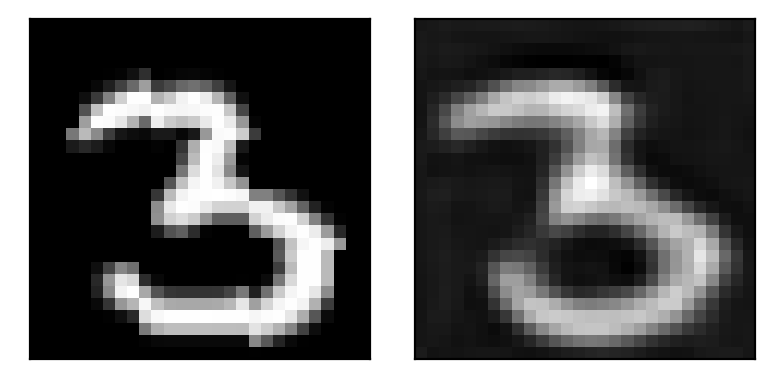

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

## Идентификация аномалий.

Идея идентификации аномалий состоит в том, чтобы разделить "обычные" экземпляры и "необычные" по значению функции потерь автокодировщика на этих примерах. Предполагается, что автокодировщик, обученный на обычных примерах не будет способен достаточно точно воспроизвести необычные примеры. То есть, значение функции потерь на необычных экземплярах будет большим. В этом ДЗ предлагается найти все экземпляры-выбросы, встречающиеся в тестовой выборке, руководствуюясь только значениями функции потерь автокодировщика. Для этого на всех объектах тестовой выборки следует вычислить функцию потерь обученного автокодировщика, и определить, какие экземпляры являются аномальными.

В качестве решения всего задания следует получить список значений 0 или 1, соответствующих объектам тестовой выборки. Признак `1` означает, что этот объект является аномалией, `0` - означает, что объект обычный.

Например, следующий список `[1,1,1,0,0,0,0,0,0,0,1,0]` означает, что в выборке из 12 объектов тестовой выборки аномалиями считаются первые три и предпоследний. Остальные считаются обычными.

> ВНИМАНИЕ! Сопоставление при проверке будет производиться только по номерам объектов в тестовой выборке. Поэтому выборку при вычислении функции потерь не следует перемешивать. То есть, при создании загрузчика данных `torch.utils.data.DataLoader` аргумент перемешивания должен быть выключен: `shuffle=False`

### Задание 8: примените обученную модель автокодировщика к данным тестовой выборки. Вычислите функцию потерь на каждом объекте тестовой выборки.

In [23]:
model.eval()
test_dataset = DS(mnist_test_samples, val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_function = torch.nn.MSELoss()

losses = []

with torch.no_grad():
    with tqdm(total=len(test_loader)) as pbar:
        for data in test_loader:
            ## здесь следует вычислить значения функции потерь для всех элементов тестовой выборки.
            curr_loss = 0.0
            data = data.to(device)
            pred = model(data)
            curr_loss = loss_function(pred, data).item()
            
            losses.append(curr_loss)
            pbar.update(1)

100%|██████████| 10000/10000 [00:09<00:00, 1002.86it/s]


## Анализ значений функции потерь
Проанализируйте распределение значений функции потерь и найдите объекты, на которых она слишком большая.

### Задание 9:
- Отобразите гистограмму значений функции потерь. Сделайте выводы (напишите ТЕКСТ) относительно значений для обычных объектов и аномалий.
- Найдите объекты-аномалии, отобразите их.
- Вычислите на них обученный вами автокодировщик. Отобразите рядом объекты-аномалии и их реконструкцию, вычисленную вашим автокодировщиком.

(0.0, 10.0)

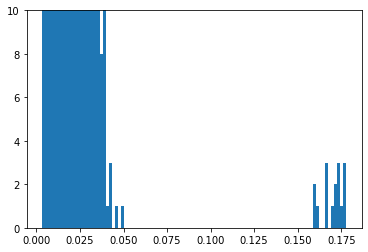

In [24]:
plt.hist(losses, bins = 100)
plt.ylim(0,10)

Довольно легко обнаружить, что объекты имеющие Loss около 0.175 должны сильно отличаться от тех объектов, на которых училась наша модель.    
Подсчитаем их количество и проведем визуализацию.      


In [25]:
counter = 0
corr_counter = 0
corrupt_indices=[]
bad_indices=[]
for item in losses:
  if item >= 0.10:
    corr_counter += 1
    corrupt_indices.append(losses.index(item))
  if item > 0.04 and item <= 0.10:
    counter += 1
    bad_indices.append(losses.index(item))
print('corrupted:', corr_counter,':', corrupt_indices)
print('high loss:', counter,':', bad_indices)

corrupted: 16 : [311, 1619, 1774, 3194, 3474, 3592, 3603, 4007, 5367, 5455, 6573, 8284, 8337, 8659, 9170, 9783]
high loss: 5 : [744, 1526, 3812, 7945, 8975]


Визуализация показала, что все 16 объектов, лежащие в кластере, имеющем высокое значение функции потерь являются шумом, тем не менее, тк autoencoder натренирован на восстановление цифр из скрытых представлений, из шума восстанавливаются фигуры, тоже состоящее из линий, лежащих так же в центральной области. Видим, что на края картинок внимание при восстановлении не обращается.   

Чтобы удостовериться, что мы нашли все порченные картинки, посмотрим, как выглядят элементы Мниста, лежащие на краю первого кластера (имеющие значение функции потерь больше 0.04). Таких элементов всего 5 и все они являются обычными цифрами (только криво написанными, поэтому восстановление происходит не всего удачно).

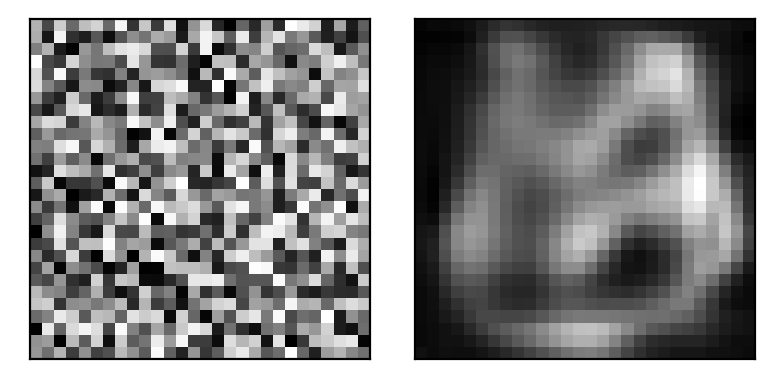

In [26]:
index = corrupt_indices[0]
sample = test_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

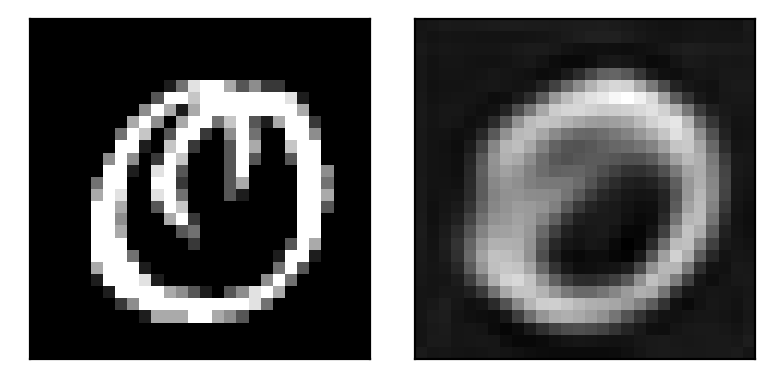

In [30]:
index = bad_indices[1]
sample = test_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

### Задание 10: создайте файл маркировки аномалий

В этом задании требуется записать в файл признаки аномальности для всех объектов тестовой выборки в том порядке, в котором эти объекты идут в выборке. Это должен быть просто текстовый файл. В нем не должно быть никаких заголовков, никаких дополнительных символов. Только `0` или `1`

<br />
пример содержимого файла (для выборки длиной 244 объекта, из которых 6 оказались помечены как аномалии):

`0000000000000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000001100000000`

<br /><br />
Финальным решением этого ДЗ является этот файл. Его нужно сдать вместе с ноутбуком с вашим кодом.

In [65]:
answer = np.zeros(10000)
for i in range(len(corrupt_indices)):
  answer[corrupt_indices[i]] = 1

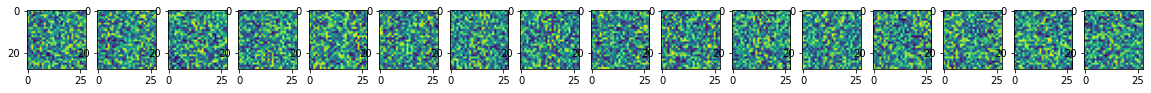

In [46]:
counter=0
fig, ax = plt.subplots(1,16, figsize=(20,10))
for i in range(len(answer)):
  if answer[i]==1:
    ax[counter].imshow(test_dataset[i][0])
    counter+=1

In [66]:
answer = answer.reshape(1,10000)

In [67]:
np.savetxt('result.txt', answer, fmt='%i', delimiter='')

In [68]:
mv result.txt drive/MyDrive/

Единственный не до конца понятный момент, который для меня остался - почему нормализация данных ухудшает процесс обучения. Процесс того, как я считал статистики показан в коде в рамках задания 2.    
Аномалии после обучения можно всё также легко найти, однако loss value для каждой из структур по результатам 10 эпох вырастает весьма значительно.